In [1]:
%tensorflow_version 1.x
import tensorflow as tf

!pip show tensorflow
!pip install tf_slim

TensorFlow 1.x selected.
Name: tensorflow
Version: 1.15.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.2/python3.6
Requires: astor, numpy, tensorflow-estimator, protobuf, gast, termcolor, keras-preprocessing, six, wrapt, grpcio, google-pasta, tensorboard, wheel, keras-applications, absl-py, opt-einsum
Required-by: stable-baselines, magenta, fancyimpute


1.2. Clone the repository of Tensorflow models

In [2]:
%cd /root/
!git clone https://github.com/tensorflow/models.git # Import required models from Github

/root
Cloning into 'models'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 48020 (delta 17), reused 29 (delta 0), pack-reused 47974
Receiving objects: 100% (48020/48020), 552.08 MiB | 38.50 MiB/s, done.
Resolving deltas: 100% (33072/33072), done.


Install Tensorboard

In [3]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-12-04 09:27:47--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.22.13.178, 54.85.41.146, 35.153.56.97, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.22.13.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  16.1MB/s    in 0.8s    

2020-12-04 09:27:49 (16.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [4]:
%cd /root/
#the logs that are created while training 
LOG_DIR = "/root/models/trained"
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
#The link to tensorboard.
#works after the training starts.
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

/root
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


1.4. Setting up an environment


In [5]:
# pip install tf-models-official


In [6]:
%cd /root/models/research/
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'
!python object_detection/builders/model_builder_test.py

/root/models/research


2. Collect images, label data set, and create label map

In [7]:
%cd /root/models/
!git clone https://github.com/fllay/totoro.git #Import Totoro and Nekobus data from Github

/root/models
Cloning into 'totoro'...
remote: Enumerating objects: 823, done.
remote: Total 823 (delta 0), reused 0 (delta 0), pack-reused 823
Receiving objects: 100% (823/823), 63.31 MiB | 44.86 MiB/s, done.
Resolving deltas: 100% (407/407), done.


3. Convert XML files to single CSV file

In [8]:
%cd /root/models/
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
	'''
    for directory in ['train','testing']:
        image_path = os.path.join(os.getcwd(), 'images/{}'.format(directory).format(directory))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv('data/{}_labels.csv'.format(directory), index=None)
        print('Successfully converted xml to csv.')
	''' 
	image_path = os.path.join(os.getcwd(), 'totoro/images/train')
	xml_df = xml_to_csv(image_path)
	xml_df.to_csv('totoro/data/train_labels.csv', index=None)

	image_path = os.path.join(os.getcwd(), 'totoro/images/test')
	xml_df = xml_to_csv(image_path)
	xml_df.to_csv('totoro/data/test_labels.csv',index=None)

main()

/root/models


4. Create TFRecords


In [9]:
%cd /root/models/totoro/tfrecord
!python generate_tfrecord.py --csv_input=/root/models/totoro/data/train_labels.csv  --output_path=train.record --image_dir=/root/models/totoro/images/train
!python generate_tfrecord.py --csv_input=/root/models/totoro/data/test_labels.csv  --output_path=test.record --image_dir=/root/models/totoro/images/test

/root/models/totoro/tfrecord


W1204 09:28:02.250815 139804872615808 module_wrapper.py:139] From generate_tfrecord.py:90: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W1204 09:28:02.366832 139804872615808 module_wrapper.py:139] From generate_tfrecord.py:49: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /root/models/totoro/tfrecord/train.record


W1204 09:28:04.742442 139889371080576 module_wrapper.py:139] From generate_tfrecord.py:90: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W1204 09:28:04.750187 139889371080576 module_wrapper.py:139] From generate_tfrecord.py:49: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /root/models/totoro/tfrecord/test.record


5. Download Pre-trained model


In [10]:
%cd ~/models

import os
import shutil
import glob
import urllib
import tarfile
from requests import get

MODEL = 'ssd_mobilenet_v1_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  print("!")
  with open(MODEL_FILE, "wb") as file:
    # get request
    response = get(DOWNLOAD_BASE + MODEL_FILE)
    # write to file
    file.write(response.content)
    #opener = urllib.URLopener()
    #opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/root/models
!


6. Modify the config file


In [11]:
%tensorflow_version 1.x
!pip show tensorflow


Name: tensorflow
Version: 1.15.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.2/python3.6
Requires: numpy, opt-einsum, protobuf, wheel, keras-applications, google-pasta, gast, tensorboard, termcolor, grpcio, wrapt, tensorflow-estimator, keras-preprocessing, absl-py, six, astor
Required-by: stable-baselines, magenta, fancyimpute


In [15]:
%cd /root/models/research/
!protoc object_detection/protos/*.proto --python_out=.
#!export PYTHONPATH=$PYTHONPATH: /usr/local/lib/python3.6/dist-packages/tensorflow/models/research/:/usr/local/lib/python3.6/dist-packages/tensorflow/models/research/slim
#!pwd
#!python /usr/local/lib/python3.6/dist-packages/tensorflow/models/research/object_detection/builders/model_builder_test.py
#!python setup.py build
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'

# Edit Pipeline 
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

pipeline = pipeline_pb2.TrainEvalPipelineConfig()                                                                                                                                                                                                          
config_path = '/root/models/ssd_mobilenet_v1_coco.config'
with tf.gfile.GFile( config_path, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline)

pipeline.train_input_reader.tf_record_input_reader.input_path[:] = ['/root/models/totoro/tfrecord/train.record'] 
pipeline.train_input_reader.label_map_path = '/root/models/totoro/data/object-detection.pbtxt'
pipeline.eval_input_reader[0].tf_record_input_reader.input_path[:] = ['/root/models/totoro/tfrecord/test.record'] 
pipeline.eval_input_reader[0].label_map_path = '/root/models/totoro/data/object-detection.pbtxt'
pipeline.train_config.fine_tune_checkpoint = '/root/models/pretrained_model/model.ckpt'
pipeline.train_config.num_steps = 500
pipeline.model.ssd.num_classes = 2
pipeline.eval_config.num_examples = 5

config_text = text_format.MessageToString(pipeline)                                                                                                                                                                                                        
with tf.gfile.Open( config_path, "wb") as f:                                                                                                                                                                                                                       
    f.write(config_text)

/root/models/research


7. Train our model


In [16]:
!pip show tensorflow


Name: tensorflow
Version: 1.15.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.2/python3.6
Requires: six, keras-preprocessing, absl-py, google-pasta, opt-einsum, keras-applications, astor, wrapt, grpcio, wheel, numpy, tensorboard, protobuf, tensorflow-estimator, termcolor, gast
Required-by: stable-baselines, magenta, fancyimpute


In [17]:
# Compile protobuf and change Python path
%cd /root/models/research/
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'

# Begin training
!python /root/models/research/object_detection/legacy/train.py \
    --logtostderr \
    --train_dir=/root/models/trained \
    --pipeline_config_path=/root/models/ssd_mobilenet_v1_coco.config

/root/models/research
Instructions for updating:
Use object_detection/model_main.py.
W1204 09:29:54.109018 140245885659008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/absl/app.py:251: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.
Instructions for updating:
Please switch to tf.train.create_global_step
W1204 09:29:54.129309 140245885659008 deprecation.py:323] From /root/models/research/object_detection/legacy/trainer.py:265: create_global_step (from tf_slim.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.create_global_step
INFO:tensorflow:Reading unweighted datasets: ['/root/models/totoro/tfrecord/train.record']
I1204 09:29:54.143435 140245885659008 dataset_builder.py:148] Reading unweighted datasets: ['/root/models/totoro/tfrecord/train.record']
INFO:tensorflow:Reading record datasets for input file: [

8. Export trained model


In [18]:
%cd /root/models/
#Identify the latest trained model
lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')
os.environ['last_model']=last_model

# Export trained model
!python /root/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/root/models/ssd_mobilenet_v1_coco.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model

/root/models
Instructions for updating:
Please use `layer.__call__` method instead.
W1204 09:35:05.543975 140153793996672 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I1204 09:35:06.857062 140153793996672 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1204 09:35:06.891169 140153793996672 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1204 09:35:06.924054 140153793996672 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additio

9. Classify images


In [25]:
# This is needed to display the images.
%matplotlib inline
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
# import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [20]:
!pip show tensorflow


Name: tensorflow
Version: 1.15.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.2/python3.6
Requires: wrapt, google-pasta, keras-preprocessing, tensorflow-estimator, opt-einsum, keras-applications, gast, numpy, absl-py, protobuf, grpcio, six, astor, wheel, tensorboard, termcolor
Required-by: stable-baselines, magenta, fancyimpute


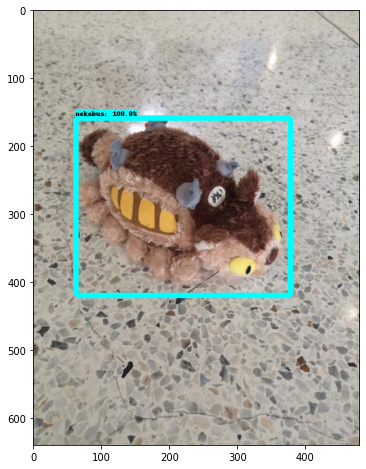

In [27]:
# What model to download.

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/root/models/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/root/models/totoro/data/object-detection.pbtxt'

NUM_CLASSES = 2


detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


# ## Loading label map
# Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

# In[7]:


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


# ## Helper code

# In[8]:


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


# # Detection

# In[9]:


# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/root/models/totoro/images/test'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 7) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS[:3]:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      image_np = vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          boxes=np.squeeze(boxes),
          classes=np.squeeze(classes).astype(np.int32),
          scores=np.squeeze(scores),
          category_index=category_index,
          use_normalized_coordinates=True,
          line_thickness=8,
          min_score_thresh=0.45)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.imsave('/root/models/0image.png',image_np )
  # plt.figure(figsize=IMAGE_SIZE)
  # plt.imshow(image_np)
  # plt.imsave('/root/models/0image.png',image_np )